In [64]:
import numpy as np
import pywt
from skimage import io
from skimage.color import rgb2ycbcr, ycbcr2rgb
import matplotlib.pyplot as plt
import arithmeticcoding as ac
import pickle

def read_image(image_path):
    image = io.imread(image_path)
    if image.shape[2] == 4:
        image = image[:, :, :3]
    #image = image[:400, :400, :]
    print("Image shape after reading:", image.shape)
    return image

def preprocess_image(image):
    ycbcr_image = rgb2ycbcr(image)
    print("Image shape after converting to YCbCr:", ycbcr_image.shape)
    ycbcr_image = ycbcr_image - 128
    return ycbcr_image

def dwt_image(image):
    channels = [pywt.dwt2(image[:, :, i], 'bior4.4') for i in range(3)]
    coeffs = [channel for channel in channels]
    return coeffs

def quantize(coeffs, quantization_steps):
    quantized_coeffs = []
    for i, channel_coeffs in enumerate(coeffs):
        LL, (LH, HL, HH) = channel_coeffs
        q_step_LL, q_step_LH, q_step_HL, q_step_HH = quantization_steps[i]
        
        LL = np.sign(LL) * np.maximum(0, np.abs(LL) - q_step_LL / 2) // q_step_LL
        LH = np.sign(LH) * np.maximum(0, np.abs(LH) - q_step_LH / 2) // q_step_LH
        HL = np.sign(HL) * np.maximum(0, np.abs(HL) - q_step_HL / 2) // q_step_HL
        HH = np.sign(HH) * np.maximum(0, np.abs(HH) - q_step_HH / 2) // q_step_HH

        quantized_coeffs.append((LL, (LH, HL, HH)))
    return quantized_coeffs



def postprocess_image(image):
    image = image + 128
    np.clip(image, 0, 255, out=image)  # Ensure values are within the valid range
    rgb_image = ycbcr2rgb(image)
    rgb_image = (rgb_image * 255).clip(0, 255)  # Scale back to [0, 255]
    print("Image shape after converting back to RGB:", rgb_image.shape)
    return rgb_image

def display_image(image):
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

def flatten_coeffs(coeffs):
    flattened = []
    shapes = []
    for channel in coeffs:
        LL, (LH, HL, HH) = channel
        shapes.append((LL.shape, LH.shape, HL.shape, HH.shape))
        flattened.extend(LL.flatten())
        flattened.extend(LH.flatten())
        flattened.extend(HL.flatten())
        flattened.extend(HH.flatten())
    return flattened, shapes



def get_coeffs_shapes(coeffs):
    shapes = []
    for channel in coeffs:
        LL, (LH, HL, HH) = channel
        shapes.append((LL.shape, LH.shape, HL.shape, HH.shape))
    return shapes

def entropy_encode(coeffs):
    flattened_coeffs, shapes = flatten_coeffs(coeffs)
    
    # Initialize a flat frequency table with 256 symbols (0 to 255)
    initfreqs = ac.FlatFrequencyTable(257)
    freqs = ac.SimpleFrequencyTable(initfreqs)
    
    # Initialize list to store encoded bits
    encoded_bits = []
    
    # Initialize bit output stream
    with open('encoded_bits.bin', 'wb') as output_file:
        bitout = ac.BitOutputStream(output_file)
        
        # Initialize arithmetic encoder with a state size of 32 bits
        encoder = ac.ArithmeticEncoder(32, bitout)
        
        # Encoding loop
        for coeff in flattened_coeffs:
            sign = 1 if coeff < 0 else 0
            magnitude = int(abs(coeff))  # Convert magnitude to integer
            
            # Encode sign
            encoder.write(freqs, sign)
            
            # Encode magnitude
            for _ in range(magnitude):
                encoder.write(freqs, 1)
            
            encoder.write(freqs, 0)  # End of magnitude encoding
        
        encoder.write(freqs, 256)  # EOF (end-of-file) symbol
        encoder.finish()  # Flush remaining bits
    
    # Read encoded bits from file and store them in the list
    with open('encoded_bits.bin', 'rb') as input_file:
        byte = input_file.read(1)
        while byte:
            encoded_bits.append(ord(byte))
            byte = input_file.read(1)  # Read next byte
    
    return encoded_bits, shapes

### Stream bit organization
def bitstream_organization(encoded_bits, coeffs_shapes, quantization_steps):
    """
    Organizes the encoded bits into a JPEG 2000 compliant bit-stream.
    """
    bitstream = []

    # Step 1: Create main header
    bitstream.extend(create_main_header())

    # Step 2: Create tile headers
    for channel_idx, shape in enumerate(coeffs_shapes):
        bitstream.extend(create_tile_header(channel_idx, shape, quantization_steps[channel_idx]))

    # Step 3: Organize encoded bits into packets
    packet_idx = 0
    while packet_idx < len(encoded_bits):
        # Create packet header
        packet_header = create_packet_header(packet_idx)
        bitstream.extend(packet_header)

        # Append packet data (slice of encoded bits)
        packet_data = encoded_bits[packet_idx:packet_idx + 1024]  # Example packet size of 1024 bits
        bitstream.extend(packet_data)

        packet_idx += 1024

    return bitstream

def create_main_header():
    """
    Creates the main header for the JPEG 2000 bit-stream.
    """
    header = []
    header.append(0xFF4F)  # SOC (Start of codestream)
    header.extend(create_image_and_tile_size_header())
    header.extend(create_image_characteristics_header())
    return header

def create_image_and_tile_size_header():
    """
    Creates the image and tile size header.
    """
    header = []
    header.append(0xFF51)  # SIZ marker
    header.extend([0, 0, 1, 0, 1, 0, 0, 0, 100, 0, 0, 0, 100, 0, 0, 0])  # Image size and other parameters
    return header

def create_image_characteristics_header():
    """
    Creates the image characteristics header.
    """
    header = []
    header.append(0xFF52)  # COD marker
    header.extend([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1])  # Coding parameters
    return header

def create_tile_header(channel_idx, shape, quantization_step):
    """
    Creates the tile header for a specific channel and shape.
    """
    header = []
    header.append(0xFF53)  # Tile-part header
    header.extend([channel_idx, *shape[0], *shape[1], *shape[2], *shape[3]])  # Shape and quantization
    header.extend(quantization_step)
    return header

def create_packet_header(packet_idx):
    """
    Creates the packet header for a specific packet index.
    """
    header = []
    header.append(0xFF90 + packet_idx)  # Packet header
    header.extend([0, 1, 2, 3])  # Example packet header data
    return header


def bitstream_parsing(bitstream):
    """
    Parses the JPEG 2000 bit-stream to retrieve the encoded bits, shapes, and quantization steps.
    """
    idx = 0

    # Step 1: Parse main header
    assert bitstream[idx] == 0xFF4F, "Invalid main header"
    idx += 1
    idx += len(create_image_and_tile_size_header())
    idx += len(create_image_characteristics_header())

    # Step 2: Parse tile headers
    coeffs_shapes = []
    quantization_steps = []
    while bitstream[idx] == 0xFF53:
        idx += 1
        channel_idx = bitstream[idx]
        idx += 1
        shape_LL = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        shape_LH = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        shape_HL = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        shape_HH = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        coeffs_shapes.append((shape_LL, shape_LH, shape_HL, shape_HH))
        quantization_step = (bitstream[idx], bitstream[idx + 1], bitstream[idx + 2], bitstream[idx + 3])
        idx += 4
        quantization_steps.append(quantization_step)

    # Step 3: Parse packets to get encoded bits
    encoded_bits = []
    while idx < len(bitstream):
        if bitstream[idx] >= 0xFF90:
            idx += 1
            packet_header_size = 4  # Assuming fixed packet header size
            idx += packet_header_size
        packet_data = bitstream[idx:idx + 1024]
        encoded_bits.extend(packet_data)
        idx += 1024

    return encoded_bits, coeffs_shapes, quantization_steps

def entropy_decode(encoded_bits):
    with open('encoded_bits.bin', 'wb') as output_file:
        output_file.write(bytearray(encoded_bits))
    
    with open('encoded_bits.bin', 'rb') as input_file:
        bitin = ac.BitInputStream(input_file)
        initfreqs = ac.FlatFrequencyTable(257)
        freqs = ac.SimpleFrequencyTable(initfreqs)
        decoder = ac.ArithmeticDecoder(32, bitin)
        
        decoded_coeffs = []
        while True:
            sign = decoder.read(freqs)
            if sign == 256:
                break
            magnitude = 0
            while True:
                bit = decoder.read(freqs)
                if bit == 0:
                    break
                magnitude += 1
            decoded_coeffs.append(((-1) ** sign) * magnitude)
        
    return decoded_coeffs



def reshape_coeffs(flattened, coeffs_shapes):
    reshaped = []
    idx = 0
    for shape in coeffs_shapes:
        LL_shape, LH_shape, HL_shape, HH_shape = shape
        LL = np.reshape(flattened[idx:idx + np.prod(LL_shape)], LL_shape)
        idx += np.prod(LL_shape)
        LH = np.reshape(flattened[idx:idx + np.prod(LH_shape)], LH_shape)
        idx += np.prod(LH_shape)
        HL = np.reshape(flattened[idx:idx + np.prod(HL_shape)], HL_shape)
        idx += np.prod(HL_shape)
        HH = np.reshape(flattened[idx:idx + np.prod(HH_shape)], HH_shape)
        idx += np.prod(HH_shape)
        reshaped.append((LL, (LH, HL, HH)))
    return reshaped

def inverse_quantize(coeffs, quantization_steps):
    inverse_quantized_coeffs = []
    for i, channel_coeffs in enumerate(coeffs):
        LL, (LH, HL, HH) = channel_coeffs
        q_step_LL, q_step_LH, q_step_HL, q_step_HH = quantization_steps[i]
        
        LL = np.sign(LL) * (np.abs(LL) * q_step_LL + q_step_LL / 2)
        LH = np.sign(LH) * (np.abs(LH) * q_step_LH + q_step_LH / 2)
        HL = np.sign(HL) * (np.abs(HL) * q_step_HL + q_step_HL / 2)
        HH = np.sign(HH) * (np.abs(HH) * q_step_HH + q_step_HH / 2)

        inverse_quantized_coeffs.append((LL, (LH, HL, HH)))
    return inverse_quantized_coeffs

def idwt_image(coeffs):
    channels = [pywt.idwt2(channel_coeffs, 'bior4.4') for channel_coeffs in coeffs]
    reconstructed_image = np.stack(channels, axis=-1)
    return reconstructed_image

def postprocess_image(image):
    image = image + 128
    np.clip(image, 0, 255, out=image)
    rgb_image = ycbcr2rgb(image)
    rgb_image = (rgb_image * 255).clip(0, 255)
    return rgb_image

Image shape after reading: (512, 512, 3)


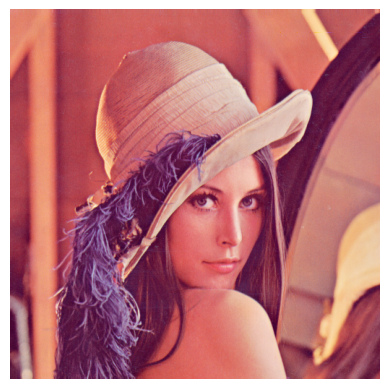

Image shape after converting to YCbCr: (512, 512, 3)


In [65]:
image_path = 'C:\\Users\\saioc\\Desktop\\Lenna.png'
image = read_image(image_path)
display_image(image)
#print(image)
preprocessed_image = preprocess_image(image)

coeffs = dwt_image(preprocessed_image)
#print(coeffs)

# Define quantization steps for different subbands
quantization_steps = [
    (0.67188, 1.05209, 5.37500, 8.41675),  
    (0.72992, 1.04584, 2.91966, 4.18337),  
    (0.72992, 1.04584, 2.91966, 4.18337),
]

quantized_coeffs = quantize(coeffs, quantization_steps)

encoded_bits, shapes = entropy_encode(quantized_coeffs)

In [66]:
bitstream = bitstream_organization(encoded_bits, shapes, quantization_steps)
print(len(bitstream))
print(bitstream[:100])  # Print the first 100 bits of the bitstream for verification

17701913
[65359, 65361, 0, 0, 1, 0, 1, 0, 0, 0, 100, 0, 0, 0, 100, 0, 0, 0, 65362, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 65363, 0, 260, 260, 260, 260, 260, 260, 260, 260, 0.67188, 1.05209, 5.375, 8.41675, 65363, 1, 260, 260, 260, 260, 260, 260, 260, 260, 0.72992, 1.04584, 2.91966, 4.18337, 65363, 2, 260, 260, 260, 260, 260, 260, 260, 260, 0.72992, 1.04584, 2.91966, 4.18337, 65424, 0, 1, 2, 3, 0, 0, 255, 0, 254, 251, 245, 234, 220, 201, 173, 136, 92, 38, 231, 153, 64, 219, 100, 225, 74]


In [67]:
####### Decoder 
dencoded_bits, dshapes, dquantization_steps = bitstream_parsing(bitstream)



In [68]:

print(encoded_bits[:100])
print(dencoded_bits[:100])

[0, 0, 255, 0, 254, 251, 245, 234, 220, 201, 173, 136, 92, 38, 231, 153, 64, 219, 100, 225, 74, 164, 236, 32, 65, 75, 62, 29, 226, 144, 36, 159, 253, 63, 99, 104, 80, 24, 192, 70, 171, 234, 6, 254, 209, 123, 253, 88, 138, 147, 111, 31, 163, 249, 35, 29, 230, 129, 233, 31, 33, 239, 139, 240, 30, 23, 214, 95, 173, 192, 154, 57, 153, 191, 165, 77, 181, 221, 196, 105, 203, 237, 13, 180, 185, 58, 132, 2, 56, 37, 200, 33, 47, 241, 103, 143, 105, 247, 51, 31]
[0, 0, 255, 0, 254, 251, 245, 234, 220, 201, 173, 136, 92, 38, 231, 153, 64, 219, 100, 225, 74, 164, 236, 32, 65, 75, 62, 29, 226, 144, 36, 159, 253, 63, 99, 104, 80, 24, 192, 70, 171, 234, 6, 254, 209, 123, 253, 88, 138, 147, 111, 31, 163, 249, 35, 29, 230, 129, 233, 31, 33, 239, 139, 240, 30, 23, 214, 95, 173, 192, 154, 57, 153, 191, 165, 77, 181, 221, 196, 105, 203, 237, 13, 180, 185, 58, 132, 2, 56, 37, 200, 33, 47, 241, 103, 143, 105, 247, 51, 31]


In [69]:
print(len(encoded_bits))
print(len(dencoded_bits))

17615824
17615824


In [70]:
decoded_flat_coeffs = entropy_decode(dencoded_bits)

In [71]:

print(quantized_coeffs[:100])
print(decoded_flat_coeffs[:100])

[(array([[  80.,   80.,   80., ...,   64.,    8.,  104.],
       [  79.,   80.,   81., ...,   53.,   -2.,   96.],
       [  80.,   80.,   80., ...,   57.,    0.,   99.],
       ...,
       [-198., -216., -224., ...,  -67.,  -63.,  -72.],
       [-195., -214., -222., ...,  -64.,  -57.,  -72.],
       [-203., -219., -225., ...,  -74.,  -78.,  -71.]]), (array([[ 0., -0., -0., ...,  3.,  3.,  2.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       [-2., -1., -1., ..., -2., -4.,  0.],
       [-2.,  0.,  1., ..., -1., -2., -3.]]), array([[-0.,  0.,  0., ...,  1., -2.,  0.],
       [-0.,  0., -0., ...,  1., -1.,  0.],
       [-0.,  0., -0., ...,  1., -1.,  0.],
       ...,
       [-1., -0.,  0., ..., -0.,  0.,  0.],
       [-1., -0.,  0., ..., -0.,  0.,  0.],
       [-1., -0.,  0., ...,  0.,  0.,  0.]]), array([[-0., -0.,  0., ...,  0., -0.,  0.],
       [ 0., -0.,  0., ..., -0.,  0., -0.],
   

In [72]:
reshaped_coeffs = reshape_coeffs(decoded_flat_coeffs, shapes)

print(quantized_coeffs[:100])
print(reshaped_coeffs[:100])

[(array([[  80.,   80.,   80., ...,   64.,    8.,  104.],
       [  79.,   80.,   81., ...,   53.,   -2.,   96.],
       [  80.,   80.,   80., ...,   57.,    0.,   99.],
       ...,
       [-198., -216., -224., ...,  -67.,  -63.,  -72.],
       [-195., -214., -222., ...,  -64.,  -57.,  -72.],
       [-203., -219., -225., ...,  -74.,  -78.,  -71.]]), (array([[ 0., -0., -0., ...,  3.,  3.,  2.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       [-2., -1., -1., ..., -2., -4.,  0.],
       [-2.,  0.,  1., ..., -1., -2., -3.]]), array([[-0.,  0.,  0., ...,  1., -2.,  0.],
       [-0.,  0., -0., ...,  1., -1.,  0.],
       [-0.,  0., -0., ...,  1., -1.,  0.],
       ...,
       [-1., -0.,  0., ..., -0.,  0.,  0.],
       [-1., -0.,  0., ..., -0.,  0.,  0.],
       [-1., -0.,  0., ...,  0.,  0.,  0.]]), array([[-0., -0.,  0., ...,  0., -0.,  0.],
       [ 0., -0.,  0., ..., -0.,  0., -0.],
   

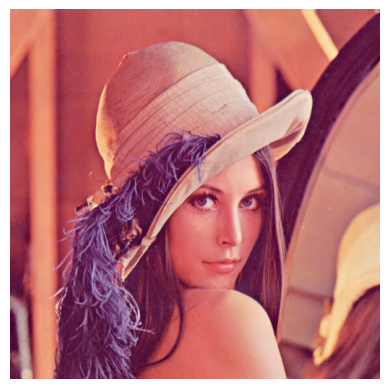

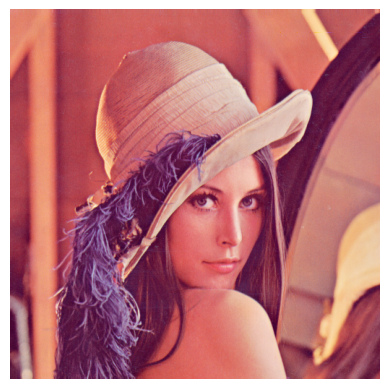

In [73]:

inverse_quantized_coeffs = inverse_quantize(reshaped_coeffs, quantization_steps)
inverse_idt = idwt_image(inverse_quantized_coeffs)
postprocessed_image = postprocess_image(inverse_idt)
display_image(postprocessed_image)
#print(postprocessed_image)
display_image(image)

In [74]:

from numpy import std

i1=image
i2=postprocessed_image

std(i1-i2)

3.188624324053955

In [75]:
# e-14 dupa procesare
# e-11 dupa idwt
# 5.48 dupa quantizare
# 5.48 dupa entropy encoding
# 5.48 dupa bitstream organization




In [76]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
def calculate_metrics(original, compressed):
    psnr = peak_signal_noise_ratio(original, compressed)
    mse = mean_squared_error(original, compressed)
    std_diff = np.std(original - compressed)
    return psnr, mse, std_diff


In [77]:
jpeg_psnr, jpeg_mse, jpeg_std_diff = calculate_metrics(i1, i2)

print("Comparison between original and JPEG:")
print(f"PSNR: {jpeg_psnr} dB")
print(f"MSE: {jpeg_mse}")
print(f"Std Difference: {jpeg_std_diff}")

Comparison between original and JPEG:
PSNR: 38.0091284269488 dB
MSE: 10.284129060426826
Std Difference: 3.188624324053955


C:\Users\saioc\AppData\Local\Temp\ipykernel_6932\3985556928.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(original, compressed)


In [78]:
import os
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

# Define paths
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
input_image_path = os.path.join(desktop_path, 'Lenna.png')
jpeg_image_path = os.path.join(desktop_path, 'Lenna.jpg')


# Load the original image
original_image = Image.open(input_image_path)
original_image_array = np.array(original_image)

# Save as JPEG
original_image.save(jpeg_image_path, 'JPEG')


# Load the converted images
jpeg_image = Image.open(jpeg_image_path)
jpeg_image_array = np.array(jpeg_image)

# Function to calculate metrics
def calculate_metrics(original, compressed):
    psnr = peak_signal_noise_ratio(original, compressed)
    mse = mean_squared_error(original, compressed)
    std_diff = np.std(original - compressed)
    return psnr,  mse, std_diff

# Calculate metrics for JPEG
jpeg_psnr, jpeg_mse, jpeg_std_diff = calculate_metrics(original_image_array, jpeg_image_array)


# Print the results
print("Comparison between original and JPEG:")
print(f"PSNR: {jpeg_psnr} dB")
print(f"MSE: {jpeg_mse}")
print(f"Std Difference: {jpeg_std_diff}")



Comparison between original and JPEG:
PSNR: 33.209323745637704 dB
MSE: 31.056176503499348
Std Difference: 123.55827499108707


In [80]:
i2_uint8 = i2.astype(np.uint8)
jpeg_psnr, jpeg_mse, jpeg_std_diff = calculate_metrics(i1, i2_uint8)

print("Comparison between original and JPEG2000:")
print(f"PSNR: {jpeg_psnr} dB")
print(f"MSE: {jpeg_mse}")
print(f"Std Difference: {jpeg_std_diff}")

Comparison between original and JPEG2000:
PSNR: 37.73278610305402 dB
MSE: 10.95977783203125
Std Difference: 116.12995428163002
